In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

## Problem 2 (b)

In [3]:
import numpy as np

# Training data for politics and sport documents
xP = np.array([
    [1, 0, 1, 1, 1, 0, 1, 1],  # Politics
    [0, 0, 0, 1, 0, 0, 1, 1],
    [1, 0, 0, 1, 1, 0, 1, 0],
    [0, 1, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 1, 1, 0, 0, 1]
])

xS = np.array([
    [1, 1, 0, 0, 0, 0, 0, 0],  # Sport
    [0, 0, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 1],
    [1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0]
])

# Test point
x = np.array([1, 0, 0, 1, 1, 1, 1, 0])

# ML estimates of p(x=1|class)
thetaP = np.mean(xP, axis=0)
thetaS = np.mean(xS, axis=0)

print(f"thetaP: {thetaP}")
print(f"thetaS: {thetaS}")

# ML class priors
pP = xP.shape[0] / (xP.shape[0] + xS.shape[0])
pS = 1 - pP

# Bayesian numerators: prob(x|xP)*pP and prob(x|xS)*pS
yP = np.prod(thetaP**x * (1 - thetaP)**(1 - x)) * pP
yS = np.prod(thetaS**x * (1 - thetaS)**(1 - x)) * pS

print(thetaP**x)
print((1 - thetaP)**(1 - x))

print(f"yP: {yP}")
print(f"yS: {yS}")

# Posterior probability of the document being about politics
prob_politics = yP / (yP + yS)

print("Posterior probability that the document is about politics:", prob_politics)


thetaP: [0.33333333 0.16666667 0.16666667 0.83333333 0.83333333 0.16666667
 0.66666667 0.83333333]
thetaS: [0.66666667 0.66666667 0.16666667 0.66666667 0.16666667 0.16666667
 0.         0.16666667]
[0.33333333 1.         1.         0.83333333 0.83333333 0.16666667
 0.66666667 1.        ]
[1.         0.83333333 0.83333333 1.         1.         1.
 1.         0.16666667]
yP: 0.001488435451912818
yS: 0.0
Posterior probability that the document is about politics: 1.0


## Que 3

In [4]:
df = pd.read_csv('./wine+quality/winequality-red.csv', sep=';')
df.rename(columns={"quality": "label"}, inplace=True)
# label <7 = 0, label >=7 = 1
df['label'] = df['label'].apply(lambda x: 1 if x >= 7 else 0)

In [14]:
# split data into training and test sets
def split_data(data, split_ratio=0.8, seed=None):
    # get 80% train and 20% test split, randomly, specifying seed for reproducibility
    if (seed):
        train = data.sample(frac=split_ratio, random_state=seed)
    else:
        train = data.sample(frac=split_ratio)
    test = data.drop(train.index)
    return train, test

train, test = split_data(df)

print(f"Train shape: {train.shape}")


Train shape: (1279, 12)


In [15]:
seed = 42
train, test = split_data(df)
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label
464,11.5,0.315,0.54,2.1,0.084,5.0,15.0,0.99870,2.98,0.70,9.2,0
1561,7.8,0.600,0.26,2.0,0.080,31.0,131.0,0.99622,3.21,0.52,9.9,0
567,8.7,0.700,0.24,2.5,0.226,5.0,15.0,0.99910,3.32,0.60,9.0,0
1311,6.5,0.510,0.15,3.0,0.064,12.0,27.0,0.99290,3.33,0.59,12.8,0
1322,9.1,0.340,0.42,1.8,0.058,9.0,18.0,0.99392,3.18,0.55,11.4,0


In [7]:
# print count unique values in each feature
print(len(train['alcohol']))
print(np.unique(train['alcohol']))

1279
[ 8.4         8.5         8.7         8.8         9.          9.05
  9.1         9.2         9.23333333  9.25        9.3         9.4
  9.5         9.55        9.56666667  9.6         9.7         9.8
  9.9         9.95       10.         10.03333333 10.1        10.2
 10.3        10.4        10.5        10.55       10.6        10.7
 10.75       10.8        10.9        11.         11.1        11.2
 11.3        11.4        11.5        11.6        11.7        11.8
 11.9        11.95       12.         12.1        12.2        12.3
 12.4        12.5        12.6        12.7        12.8        12.9
 13.         13.1        13.2        13.3        13.4        13.5
 13.6        14.         14.9       ]


In [15]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

In [23]:
# univariate decision tree using entropy and information gain
class decisionTrees:
    def __init__(self, data, target, criterion='entropy'):
        self.data = data
        self.target = target
        self.criterion = criterion

    def entropy(self, data):
        # get unique values and counts
        unique, counts = np.unique(data, return_counts=True)
        # calculate probability of each unique value
        prob = counts / len(data)
        # calculate entropy
        entropy = -np.sum(prob * np.log2(prob))
        return entropy
    
    def entropy2(self, data_l, data_r):
        # calculate entropy
        n = len(data_l) + len(data_r)
        p_l = len(data_l) / n
        p_r = len(data_r) / n
        entropy = p_l * self.entropy(data_l) + p_r * self.entropy(data_r)
        return entropy
    
    def information_gain(self, data, feature):
        # get unique values and counts
        unique, counts = np.unique(data[feature], return_counts=True)
        # calculate probability of each unique value
        prob = counts / len(data)
        # calculate entropy for each unique value
        entropy = np.array([self.entropy(data[data[feature] == u][self.target]) for u in unique])
        # calculate information gain
        information_gain = np.sum(prob * entropy)
        return information_gain
    
    def classify(self, data):
        # get unique values and counts
        unique, counts = np.unique(data[self.target], return_counts=True)
        # return majority class
        return unique[np.argmax(counts)]
    
    def potential_splits(self, data):
        potential_splits = {}
        for column in data.columns:
            if column != self.target:
                potential_splits[column] = np.unique(data[column])
        return potential_splits
    
    def split_data(self, data, feature, value):
        # return left and right splits
        return data[data[feature] <= value], data[data[feature] > value]
    
    def get_best_split(self, data):
        potential_splits = self.potential_splits(data)
        best_split = {}
        best_info_gain = np.inf
        for feature in potential_splits:
            for value in potential_splits[feature]:
                data_l, data_r = self.split_data(data, feature, value)
                current_info_gain = self.entropy2(data_l[self.target], data_r[self.target])
                if current_info_gain < best_info_gain:
                    best_info_gain = current_info_gain
                    best_split = {'feature': feature, 'value': value}
        return best_split
    
    def tree_maker(self, data, curr_depth=0, min_samples=2, max_depth=5):
        if len(data) < min_samples or curr_depth == max_depth:
            return self.classify(data)
        
        curr_depth += 1

        split = self.get_best_split(data)
        data_l, data_r = self.split_data(data, split['feature'], split['value'])
        question = f"{split['feature']} <= {split['value']}"
        sub_tree = {question: []}

        yes = self.tree_maker(data_l, curr_depth)
        no = self.tree_maker(data_r, curr_depth)

        if yes == no:
            sub_tree = yes
        else:
            sub_tree[question].append(yes)
            sub_tree[question].append(no)

        return sub_tree

tree = decisionTrees(train, 'label')
tree1 = tree.tree_maker(train, max_depth=3)        

In [24]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature, comparison, value = question.split()
    if example[feature] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]
    if not isinstance(answer, dict):
        return answer
    else:
        return classify_example(example, answer)
    
def calculate_accuracy(data, tree):
    data['classification'] = data.apply(classify_example, axis=1, args=(tree,))
    data['classification_correct'] = data['classification'] == data['label']
    accuracy = data['classification_correct'].mean()
    return accuracy

accuracy = calculate_accuracy(test, tree1)
print(f"Accuracy: {accuracy}")

ValueError: too many values to unpack (expected 3)

In [2]:
class Node():
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        """
        Initializes a new instance of the Node class.

        Args:
            feature: The feature used for splitting at this node. Defaults to None.
            threshold: The threshold used for splitting at this node. Defaults to None.
            left: The left child node. Defaults to None.
            right: The right child node. Defaults to None.
            gain: The gain of the split. Defaults to None.
            value: If this node is a leaf node, this attribute represents the predicted value
                for the target variable. Defaults to None.
        """
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

In [3]:
class DecisionTree():
    """
    A decision tree classifier for binary classification problems.
    """

    def __init__(self, min_samples=2, max_depth=2):
        """
        Constructor for DecisionTree class.

        Parameters:
            min_samples (int): Minimum number of samples required to split an internal node.
            max_depth (int): Maximum depth of the decision tree.
        """
        self.min_samples = min_samples
        self.max_depth = max_depth

    def split_data(self, dataset, feature, threshold):
        """
        Splits the given dataset into two datasets based on the given feature and threshold.

        Parameters:
            dataset (ndarray): Input dataset.
            feature (int): Index of the feature to be split on.
            threshold (float): Threshold value to split the feature on.

        Returns:
            left_dataset (ndarray): Subset of the dataset with values less than or equal to the threshold.
            right_dataset (ndarray): Subset of the dataset with values greater than the threshold.
        """
        # Create empty arrays to store the left and right datasets
        left_dataset = []
        right_dataset = []
        
        # Loop over each row in the dataset and split based on the given feature and threshold
        for row in dataset:
            if row[feature] <= threshold:
                left_dataset.append(row)
            else:
                right_dataset.append(row)

        # Convert the left and right datasets to numpy arrays and return
        left_dataset = np.array(left_dataset)
        right_dataset = np.array(right_dataset)
        return left_dataset, right_dataset

    def entropy(self, y):
        """
        Computes the entropy of the given label values.

        Parameters:
            y (ndarray): Input label values.

        Returns:
            entropy (float): Entropy of the given label values.
        """
        entropy = 0

        # Find the unique label values in y and loop over each value
        labels = np.unique(y)
        for label in labels:
            # Find the examples in y that have the current label
            label_examples = y[y == label]
            # Calculate the ratio of the current label in y
            pl = len(label_examples) / len(y)
            # Calculate the entropy using the current label and ratio
            entropy += -pl * np.log2(pl)

        # Return the final entropy value
        return entropy

    def information_gain(self, parent, left, right):
        """
        Computes the information gain from splitting the parent dataset into two datasets.

        Parameters:
            parent (ndarray): Input parent dataset.
            left (ndarray): Subset of the parent dataset after split on a feature.
            right (ndarray): Subset of the parent dataset after split on a feature.

        Returns:
            information_gain (float): Information gain of the split.
        """
        # set initial information gain to 0
        information_gain = 0
        # compute entropy for parent
        parent_entropy = self.entropy(parent)
        # calculate weight for left and right nodes
        weight_left = len(left) / len(parent)
        weight_right= len(right) / len(parent)
        # compute entropy for left and right nodes
        entropy_left, entropy_right = self.entropy(left), self.entropy(right)
        # calculate weighted entropy 
        weighted_entropy = weight_left * entropy_left + weight_right * entropy_right
        # calculate information gain 
        information_gain = parent_entropy - weighted_entropy
        return information_gain

    
    def best_split(self, dataset, num_samples, num_features):
        """
        Finds the best split for the given dataset.

        Args:
        dataset (ndarray): The dataset to split.
        num_samples (int): The number of samples in the dataset.
        num_features (int): The number of features in the dataset.

        Returns:
        dict: A dictionary with the best split feature index, threshold, gain, 
              left and right datasets.
        """
        # dictionary to store the best split values
        best_split = {'gain':- 1, 'feature': None, 'threshold': None}
        # loop over all the features
        for feature_index in range(num_features):
            #get the feature at the current feature_index
            feature_values = dataset[:, feature_index]
            #get unique values of that feature
            thresholds = np.unique(feature_values)
            # loop over all values of the feature
            for threshold in thresholds:
                # get left and right datasets
                left_dataset, right_dataset = self.split_data(dataset, feature_index, threshold)
                # check if either datasets is empty
                if len(left_dataset) and len(right_dataset):
                    # get y values of the parent and left, right nodes
                    y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                    # compute information gain based on the y values
                    information_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if conditions are met
                    if information_gain > best_split["gain"]:
                        best_split["feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["left_dataset"] = left_dataset
                        best_split["right_dataset"] = right_dataset
                        best_split["gain"] = information_gain
        return best_split

    
    def calculate_leaf_value(self, y):
        """
        Calculates the most occurring value in the given list of y values.

        Args:
            y (list): The list of y values.

        Returns:
            The most occurring value in the list.
        """
        y = list(y)
        #get the highest present class in the array
        most_occuring_value = max(y, key=y.count)
        return most_occuring_value
    
    def build_tree(self, dataset, current_depth=0):
        """
        Recursively builds a decision tree from the given dataset.

        Args:
        dataset (ndarray): The dataset to build the tree from.
        current_depth (int): The current depth of the tree.

        Returns:
        Node: The root node of the built decision tree.
        """
        # split the dataset into X, y values
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        # keeps spliting until stopping conditions are met
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            # Get the best split
            best_split = self.best_split(dataset, n_samples, n_features)
            # Check if gain isn't zero
            if best_split["gain"]:
                # continue splitting the left and the right child. Increment current depth
                left_node = self.build_tree(best_split["left_dataset"], current_depth + 1)
                right_node = self.build_tree(best_split["right_dataset"], current_depth + 1)
                # return decision node
                return Node(best_split["feature"], best_split["threshold"],
                            left_node, right_node, best_split["gain"])

        # compute leaf node value
        leaf_value = self.calculate_leaf_value(y)
        # return leaf node value
        return Node(value=leaf_value)
    
    def fit(self, X, y):
        """
        Builds and fits the decision tree to the given X and y values.

        Args:
        X (ndarray): The feature matrix.
        y (ndarray): The target values.
        """
        dataset = np.concatenate((X, y), axis=1)  
        self.root = self.build_tree(dataset)

    def predict(self, X):
        """
        Predicts the class labels for each instance in the feature matrix X.

        Args:
        X (ndarray): The feature matrix to make predictions for.

        Returns:
        list: A list of predicted class labels.
        """
        # Create an empty list to store the predictions
        predictions = []
        # For each instance in X, make a prediction by traversing the tree
        for x in X:
            prediction = self.make_prediction(x, self.root)
            # Append the prediction to the list of predictions
            predictions.append(prediction)
        # Convert the list to a numpy array and return it
        np.array(predictions)
        return predictions
    
    def make_prediction(self, x, node):
        """
        Traverses the decision tree to predict the target value for the given feature vector.

        Args:
        x (ndarray): The feature vector to predict the target value for.
        node (Node): The current node being evaluated.

        Returns:
        The predicted target value for the given feature vector.
        """
        # if the node has value i.e it's a leaf node extract it's value
        if node.value != None: 
            return node.value
        else:
            #if it's node a leaf node we'll get it's feature and traverse through the tree accordingly
            feature = x[node.feature]
            if feature <= node.threshold:
                return self.make_prediction(x, node.left)
            else:
                return self.make_prediction(x, node.right)

In [6]:
def accuracy(y_true, y_pred):
    """
    Computes the accuracy of a classification model.

    Parameters:
    ----------
        y_true (numpy array): A numpy array of true labels for each data point.
        y_pred (numpy array): A numpy array of predicted labels for each data point.

    Returns:
    ----------
        float: The accuracy of the model
    """
    y_true = y_true.flatten()
    total_samples = len(y_true)
    correct_predictions = np.sum(y_true == y_pred)
    return (correct_predictions / total_samples) 

In [16]:
model = DecisionTree(2, 2)

In [17]:
model.fit(train.drop('label', axis=1).values, train['label'].values.reshape(-1, 1))

In [18]:
predictions = model.predict(test.drop('label', axis=1).values)

In [19]:
print(f"Model's Accuracy: {accuracy(test['label'].values, predictions)}")

Model's Accuracy: 0.859375


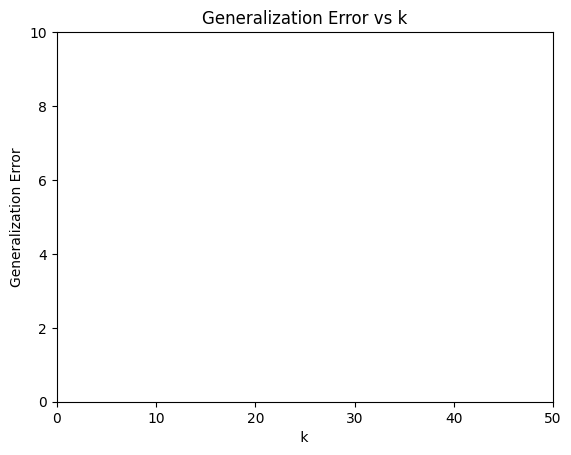

In [9]:
# make a plot for genralization error
X = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
# plt.plot(X)
plt.plot()
plt.xlim(0, 50)
plt.ylim(0, 10)
plt.xlabel(' k ')
plt.ylabel('Generalization Error')
plt.title('Generalization Error vs k')
plt.show()